In [68]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nsd_dir = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/'
fs_dir = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
# inputs
subj = utils.sub_number_to_string(1, dataset='nsdsyn')
hemi = 'lh'
design_mat = os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', subj, 'nativesurface', prep._get_beta_folder_name(3),
                     f'{hemi}.betas_nsdsynthetic.hdf5')
stim_info = os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
rois = [os.path.join(fs_dir, subj, 'label', f'{hemi}.prf-{roi}.mgz')
        for roi in ["visualrois", "eccrois"]]
rois_vals = [[1,2],[1,2,3,4,5]]
prfs = [os.path.join(fs_dir, subj, 'label', f'{hemi}.{prf_param}.mgz')
        for prf_param in ["prfeccentricity", "prfangle", "prfsize", "prfexponent", "R2"]]

In [ ]:
stim_df = prep.load_stim_info_as_df(stim_info, drop_phase=False, force_download=False)
mask, roi_dict = prep.load_common_mask_and_rois(rois, rois_vals)
prf_dict = prep.load_prf_properties_as_dict(prfs, mask, True)
stim_df = prep.find_run(design_mat, stim_df)
stim_df = stim_df.sort_values(['image_idx'])

In [5]:
from scipy.io import loadmat

bdata_path = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/bdata/nsdsynthetic/nsdsynthetic_subj01.mat'
bdata = loadmat(bdata_path)


In [ ]:
bdata_dir = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/bdata/nsdsynthetic'
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
bdata = list()

bdata_df = pd.DataFrame({})
for subj in subj_list:
    tmp_df = pd.DataFrame({})
    bdata_path = os.path.join(bdata_dir, f'nsdsynthetic_{subj}.mat')
    tmp = loadmat(bdata_path)
    tmp_df['pctcorrect'] = np.array(tmp['pctcorrect']).flatten()
    tmp_df['dprime'] = np.array(tmp['dprime']).flatten()
    tmp_df['sub'] = subj
    bdata_df = pd.concat([bdata_df, tmp_df])
    bdata.append(tmp['sdtmatrix'])
bdata = np.stack(bdata, axis=0)

In [31]:
bdata_df_long = pd.melt(bdata_df, id_vars=['sub'], var_name='task', value_name='score')

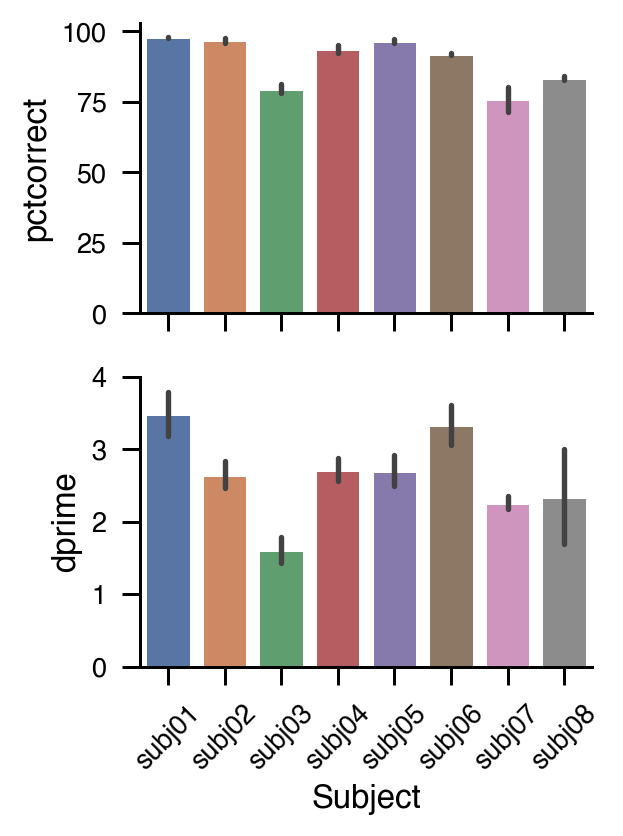

In [67]:
fig, axes = plt.subplots(2,1, figsize=(3,4), sharex=True)
rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'legend.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 3,
      'axes.spines.right': False,
      'axes.spines.top': False,
      'xtick.major.pad': 5,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 11,
      'axes.titlesize': 11,
      'axes.labelsize': 11,
      'xtick.labelsize': 9,
      'ytick.labelsize': 9,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 11,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
sns.set_theme('notebook', style='ticks', rc=rc)
axes[0] = sns.barplot(data=bdata_df, x='sub', y='pctcorrect', hue=None, ax=axes[0],  errorbar='se')
axes[0].set_xlabel('')
axes[1] = sns.barplot(data=bdata_df, x='sub', y='dprime', hue=None, ax=axes[1], errorbar='se')
axes[1].set(ylim=(0, 4), yticks=[0, 1, 2, 3, 4])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_xlabel('Subject')
fig.tight_layout()

In [71]:
precision_df = pd.read_csv(os.path.join(config['OUTPUT_DIR'], 'dataframes', 'nsdsyn', 'precision', 'precision-s_dset-nsdsyn_vs-pRFsize.csv'))

In [132]:
bdata_df_mean = bdata_df.groupby(['sub']).mean().reset_index()
precision_bdata_df = pd.merge(precision_df, bdata_df_mean, on='sub')


for roi in ['V1', 'V2', 'V3']:
    test_df = precision_bdata_df.query('vroinames == @roi')
    corr = test_df['precision'].corr(test_df['dprime'])
    print(f'{roi}: Correlation between precision and dprime: {corr:.3f}')


V1: Correlation between precision and dprime: 0.822
V2: Correlation between precision and dprime: 0.767
V3: Correlation between precision and dprime: 0.591


In [110]:
dset='nsdsyn'
subj='subj01'
roi='V1'
vs='pRFsize'
max_epoch=30000
lr=0.0005
model_type_list = [1,2,3,4,5,6,7]
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']

In [117]:
loss_df = pd.DataFrame({})
for subj in subj_list:
    tmp = pd.DataFrame({})
    train_loss = pd.read_hdf(os.path.join(config['OUTPUT_DIR'], f'sfp_model/results_2D/nsdsyn/corrected/loss-history_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.h5'))
    tmp = pd.DataFrame({'sub': [subj], 
                        'model_type': 'train',
                        'loss': [train_loss.query('epoch == @max_epoch-1')['loss'].item()]})
    for model_type in model_type_list:
        test_loss = np.load(os.path.join(config['OUTPUT_DIR'], f'sfp_model/cross_validation/nsdsyn/model-{model_type}/cvlosses_bts-False_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.npy'))
        tmp = pd.concat([tmp, pd.DataFrame({'sub': [subj], 
                                            'model_type': [model_type],
                                            'loss': [test_loss.mean()]})], axis=0)
    loss_df = pd.concat([loss_df, tmp], axis=0, ignore_index=True)

In [133]:
normalized_df = cv2d.normalize_loss_across_model(loss_df, add_mean=True, match_broderick=True)
normalized_df = normalized_df.query('model_type == 7')
all_df = precision_bdata_df.merge(normalized_df, on='sub')
all_df = all_df.query('vroinames == "V1"')

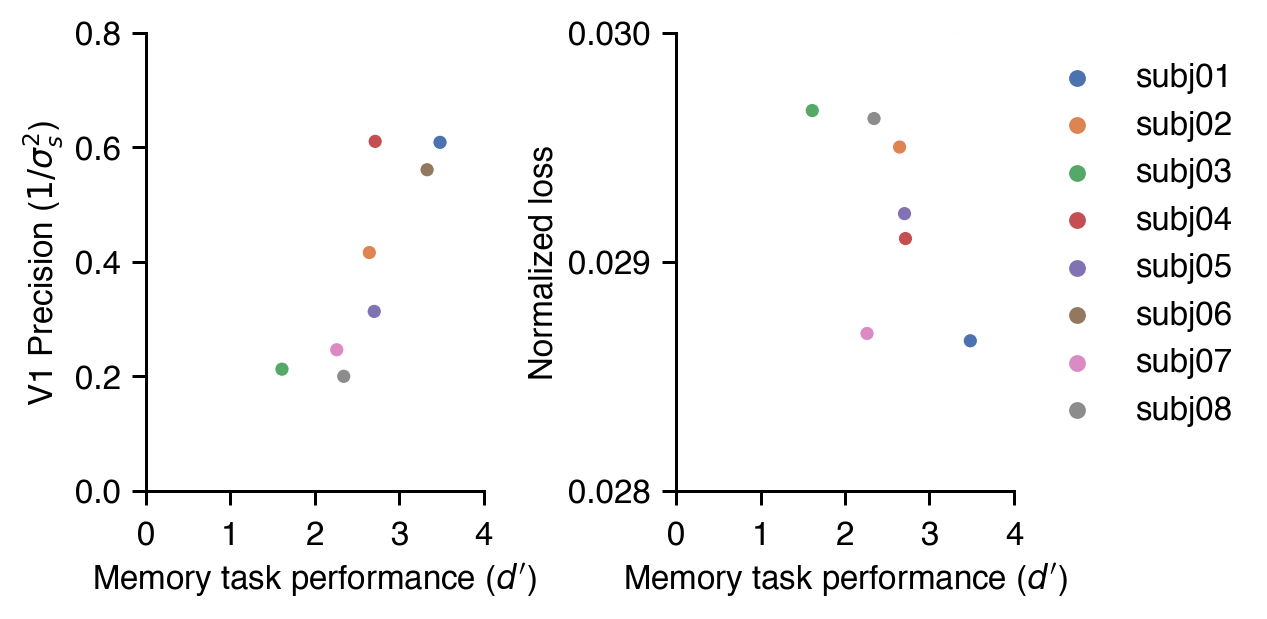

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax = vis1D.plot_v1_precision_vs_dprime(all_df,
x='dprime', y='precision', hue='sub', ax=axes[0])
# ax.text(
#     0.7, 0.4, 'corr: 0.82', 
#     ha='left', va='top', fontsize=11, color='black',
#     bbox=dict(facecolor='None', edgecolor='none', alpha=0.7)
# )

axes[0].set_ylabel(r'V1 Precision ($1/\sigma_s^2$)')
axes[0].set_xlabel(r"Memory task performance ($d'$)")
axes[0].set_ylim(0, 0.8)
axes[0].set_xlim(0,4)
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].legend_.remove()

axes[1] = vis1D.plot_v1_precision_vs_dprime(all_df,
x='dprime', y='normalized_loss', hue='sub', ax=axes[1])

axes[1].set_ylabel('Normalized loss')
axes[1].set_xlabel(r"Memory task performance ($d'$)")
axes[1].set_ylim(0.028, 0.030)
axes[1].set_yticks([0.028, 0.029, 0.030])
axes[1].set_xlim(0,4)
axes[1].set_xticks([0, 1, 2, 3, 4])

fig.tight_layout()